In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
relay_state_data = pd.read_csv("Relay States.csv")

In [3]:
display(relay_state_data.head(2))
display(relay_state_data.tail(2))

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,M3
0,0.0001,0.0001,0.000100,0.000100,10.533904,0.02,0.0001,0.0010,0.000100,0.000055,0.020028,0.004033,0.000120,0.020175,STOP
1,0.0001,0.0001,0.649088,10.533804,10.533904,0.20,0.0001,0.0001,0.000009,3.686851,2.043426,2.252111,2.755849,6.642700,RAISE


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,M3
895,0.2141,0.0001,5.464372,5.917467,10.533904,-1.746087,50.8001,38.1001,0.438246,2.113933,-0.689121,0.919143,6.647865,7.015712,RAISE
896,0.2141,0.0011,6.397617,5.069532,10.533904,0.184686,51.2001,38.4001,0.518741,1.817156,1.093264,1.127231,7.411523,9.413365,RAISE


In [4]:
display(relay_state_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N1      897 non-null    float64
 1   N2      897 non-null    float64
 2   N3      897 non-null    float64
 3   N4      897 non-null    float64
 4   N5      897 non-null    float64
 5   N6      897 non-null    float64
 6   N7      897 non-null    float64
 7   N8      897 non-null    float64
 8   N9      897 non-null    float64
 9   N10     897 non-null    float64
 10  N11     897 non-null    float64
 11  N12     897 non-null    float64
 12  N13     897 non-null    float64
 13  N14     897 non-null    float64
 14  M3      897 non-null    object 
dtypes: float64(14), object(1)
memory usage: 105.2+ KB


None

In [5]:
relay_state_data.isna().sum().sum()

0

In [6]:
relay_state_data.describe().T

,count,mean,std,min,25%,50%,75%,max
N1,897.0,0.102562,4.144493e-02,-0.000900,0.075100,0.102100,0.132100,0.218100
N2,897.0,0.046943,3.555687e-02,0.000100,0.016100,0.039100,0.072100,0.149100
N3,897.0,6.716206,2.660483e+00,0.000100,4.794128,7.110902,9.008911,11.341721
N4,897.0,3.813087,2.663513e+00,-0.807817,1.523688,3.411969,5.739776,10.533804
N5,897.0,10.533904,1.084182e-13,10.533904,10.533904,10.533904,10.533904,10.533904
N6,897.0,0.590930,5.738883e+00,-130.236576,0.165759,0.398919,1.013910,33.864220
N7,897.0,15.174203,1.245118e+01,0.000100,4.800100,12.000100,22.800100,51.200100
N8,897.0,11.380670,9.338373e+00,0.000100,3.600100,9.000100,17.100100,38.400100
N9,897.0,0.636903,2.534572e-01,0.000009,0.455020,0.675049,0.855230,1.076687
N10,897.0,1.355093,9.319090e-01,-0.262316,0.553417,1.214296,2.024717,3.686851


In [7]:
clustering_numerical_correlation = relay_state_data.select_dtypes(include='number').corr()
clustering_numerical_correlation

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14
N1,1.000000,0.327098,0.043535,-0.043098,NaN,0.062838,0.251565,0.251566,0.053880,-0.034219,0.060452,0.043620,0.040642,0.070317
N2,0.327098,1.000000,0.087550,-0.091625,NaN,-0.006534,0.617261,0.617262,0.097207,-0.088747,-0.013829,-0.047020,0.080578,0.010661
N3,0.043535,0.087550,1.000000,-0.755330,NaN,0.055609,0.020278,0.020278,0.764639,-0.755202,-0.005745,-0.295051,0.988260,0.312472
N4,-0.043098,-0.091625,-0.755330,1.000000,NaN,-0.120647,-0.016739,-0.016740,-0.991307,0.999961,-0.039715,0.346257,-0.646336,-0.206374
N5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N6,0.062838,-0.006534,0.055609,-0.120647,NaN,1.000000,-0.020606,-0.020606,0.120796,-0.120129,0.996704,0.889503,0.036622,0.952460
N7,0.251565,0.617261,0.020278,-0.016739,NaN,-0.020606,1.000000,1.000000,0.022065,-0.014507,-0.021926,-0.026146,0.019708,-0.014468
N8,0.251566,0.617262,0.020278,-0.016740,NaN,-0.020606,1.000000,1.000000,0.022065,-0.014508,-0.021926,-0.026146,0.019708,-0.014468
N9,0.053880,0.097207,0.764639,-0.991307,NaN,0.120796,0.022065,0.022065,1.000000,-0.991169,0.040584,-0.342069,0.659202,0.212787
N10,-0.034219,-0.088747,-0.755202,0.999961,NaN,-0.120129,-0.014507,-0.014508,-0.991169,1.000000,-0.039191,0.346764,-0.646196,-0.205819


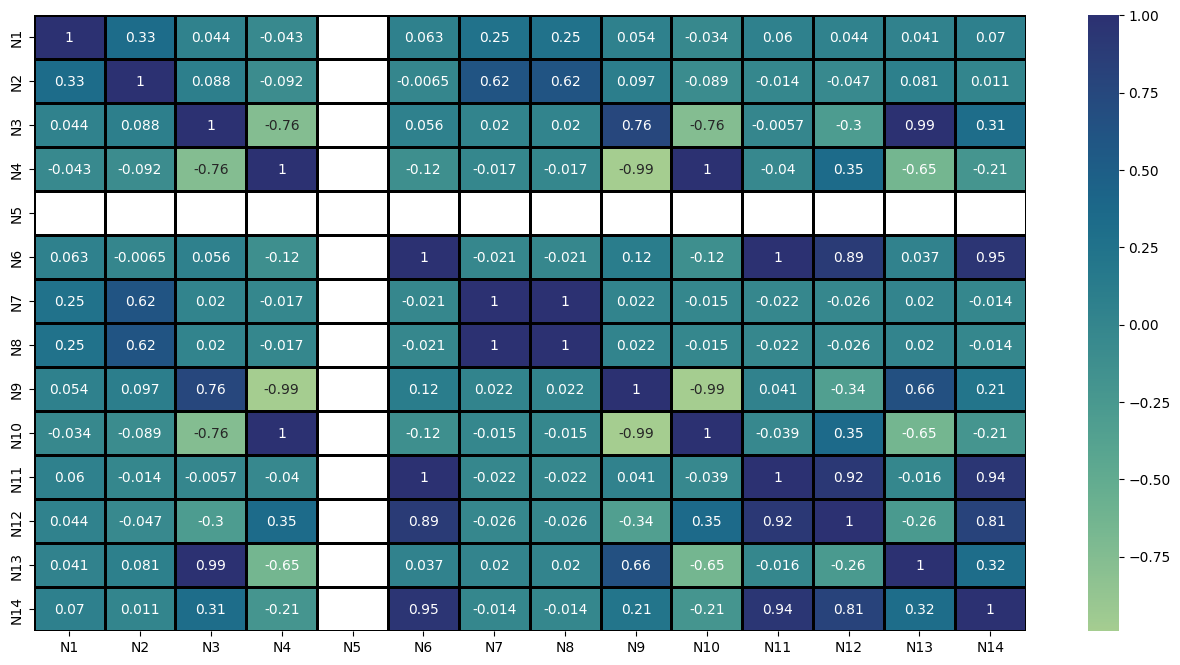

In [8]:
plt.figure(figsize=(16, 8))
sns.heatmap(data=clustering_numerical_correlation, annot=True, linewidths=0.8, linecolor='black', cmap='crest')
plt.show()

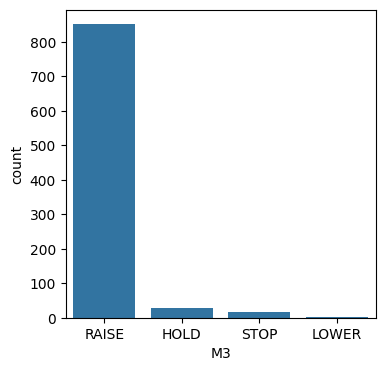

In [9]:
plt.figure(figsize=(4, 4))
sns.barplot(relay_state_data.M3.value_counts())
plt.show()

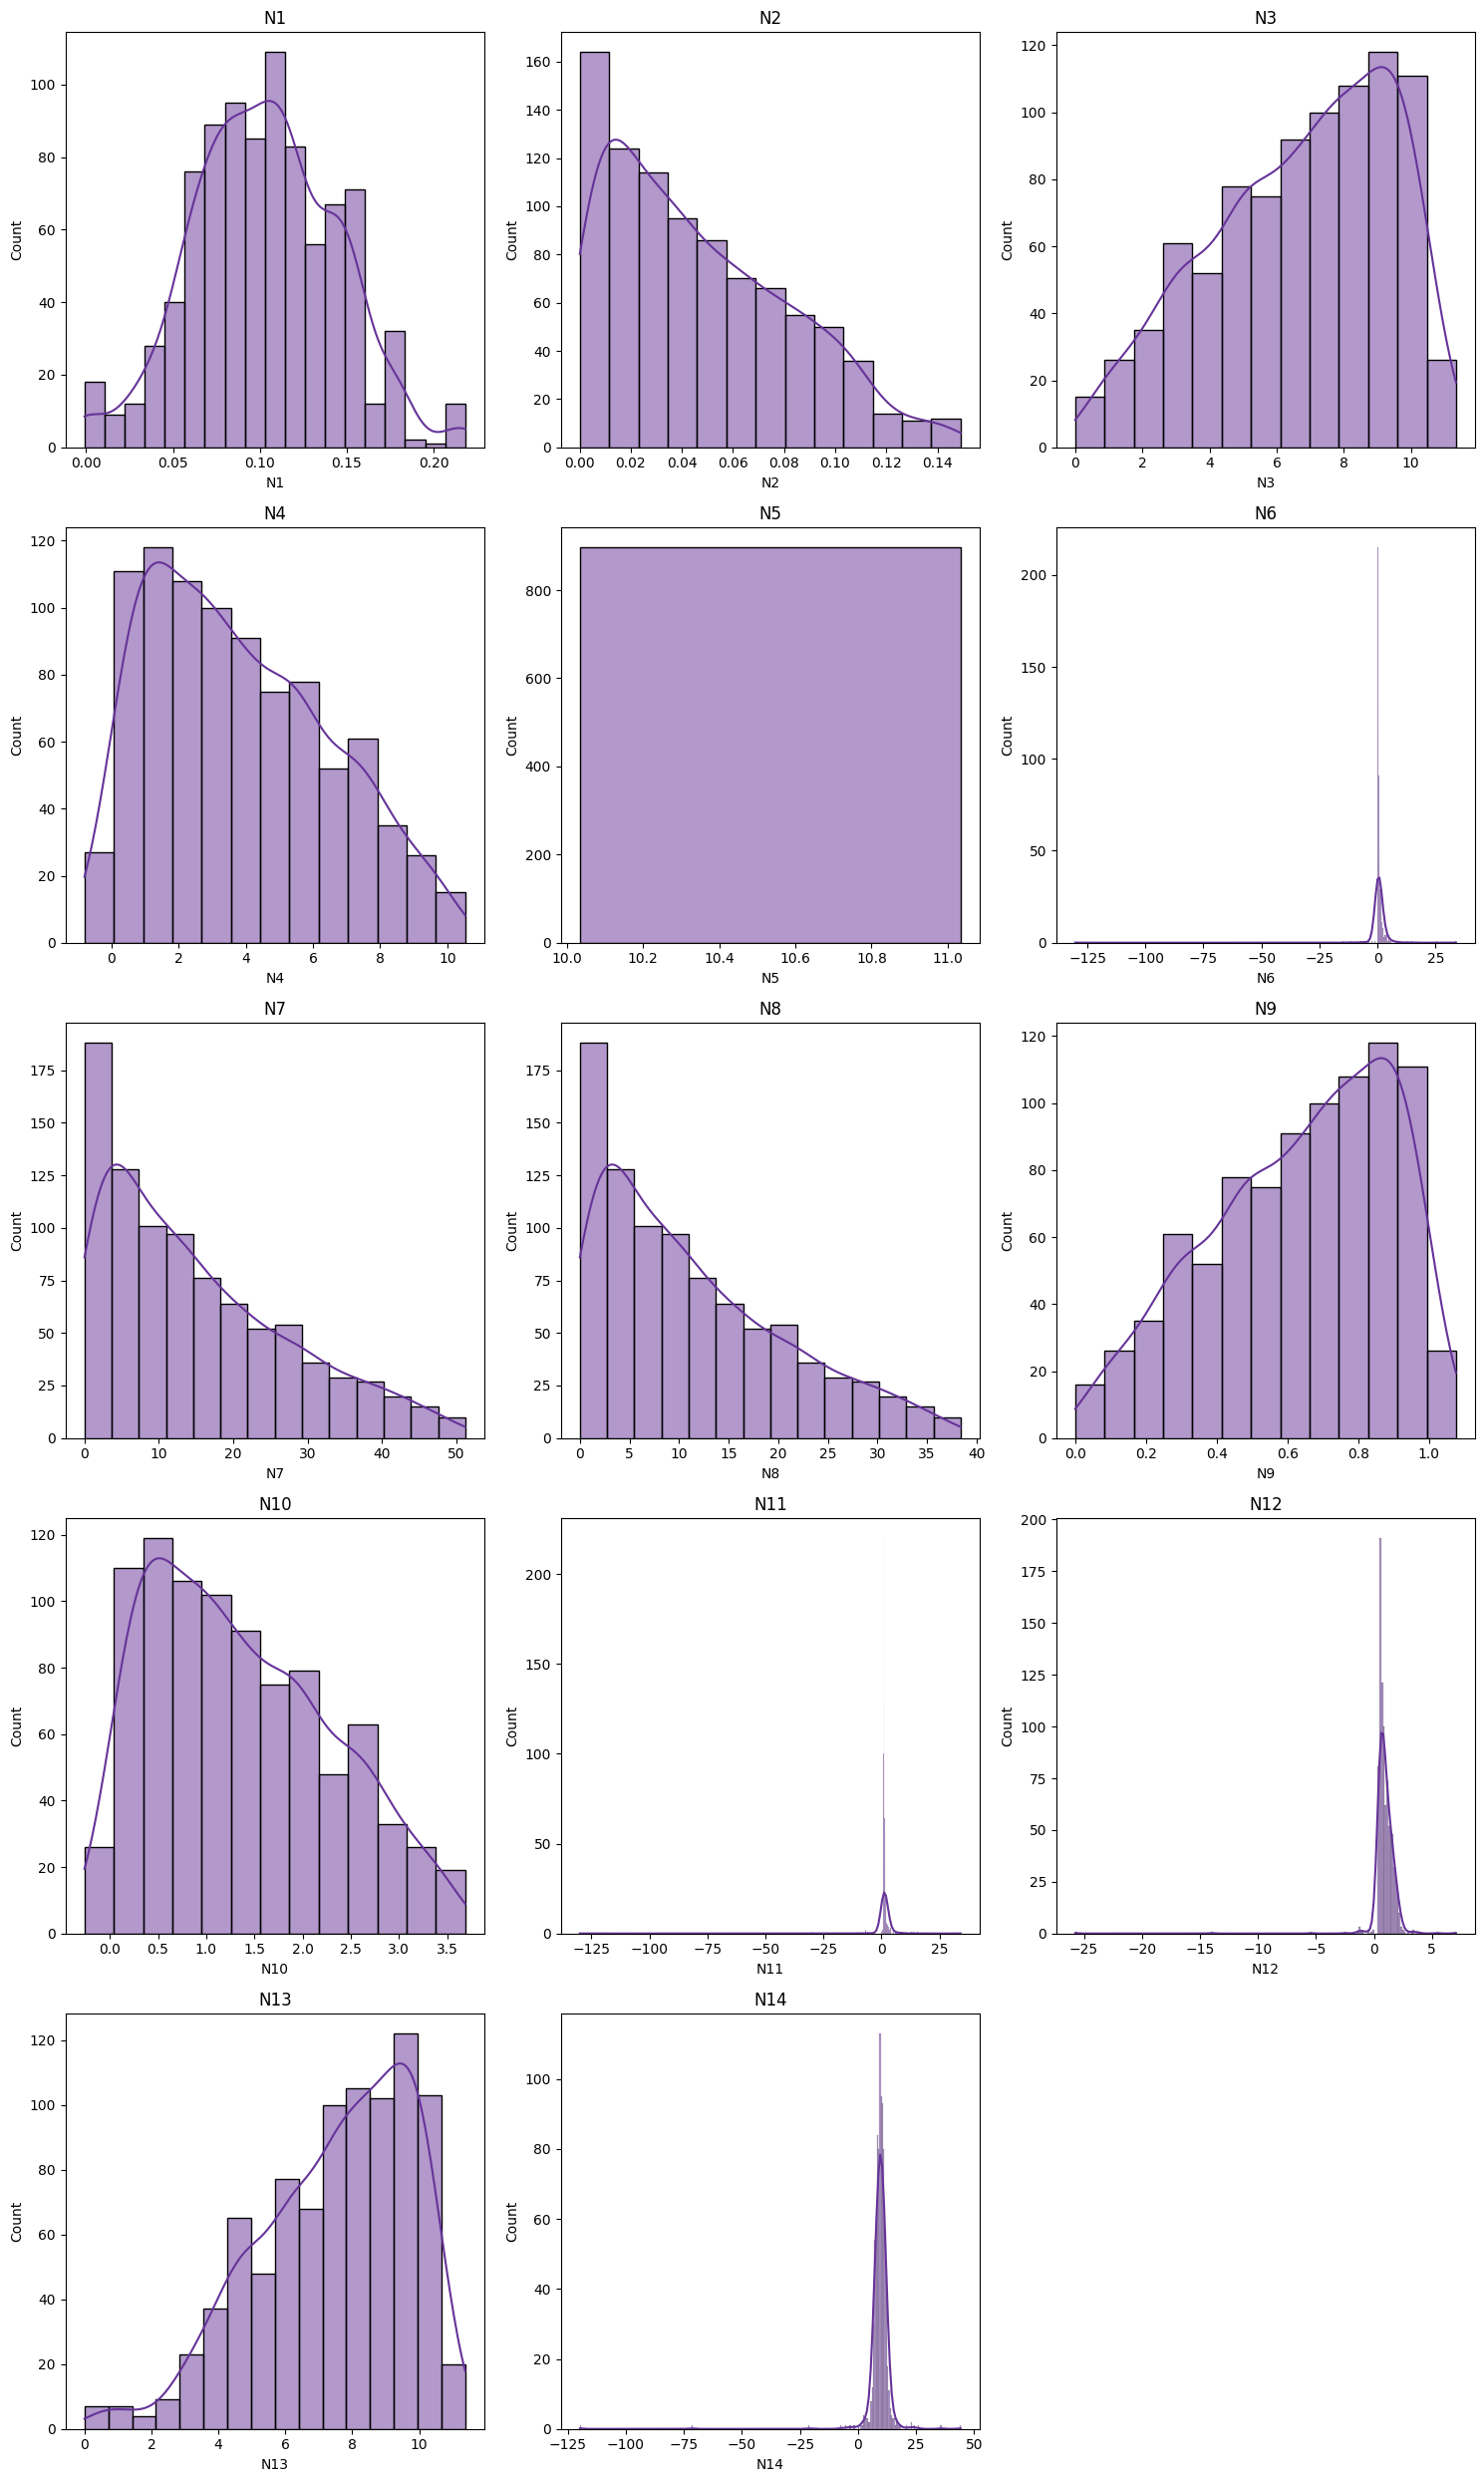

In [10]:
numerical_clustering_features = relay_state_data.select_dtypes(include='number').columns
num_cols = 3
num_rows = (len(numerical_clustering_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*5))
axes = axes.flatten()

for index, feature in enumerate(numerical_clustering_features):
    sns.histplot(data=relay_state_data, x=feature, ax=axes[index], kde=True, color='rebeccapurple')
    axes[index].set_title(feature.title())

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

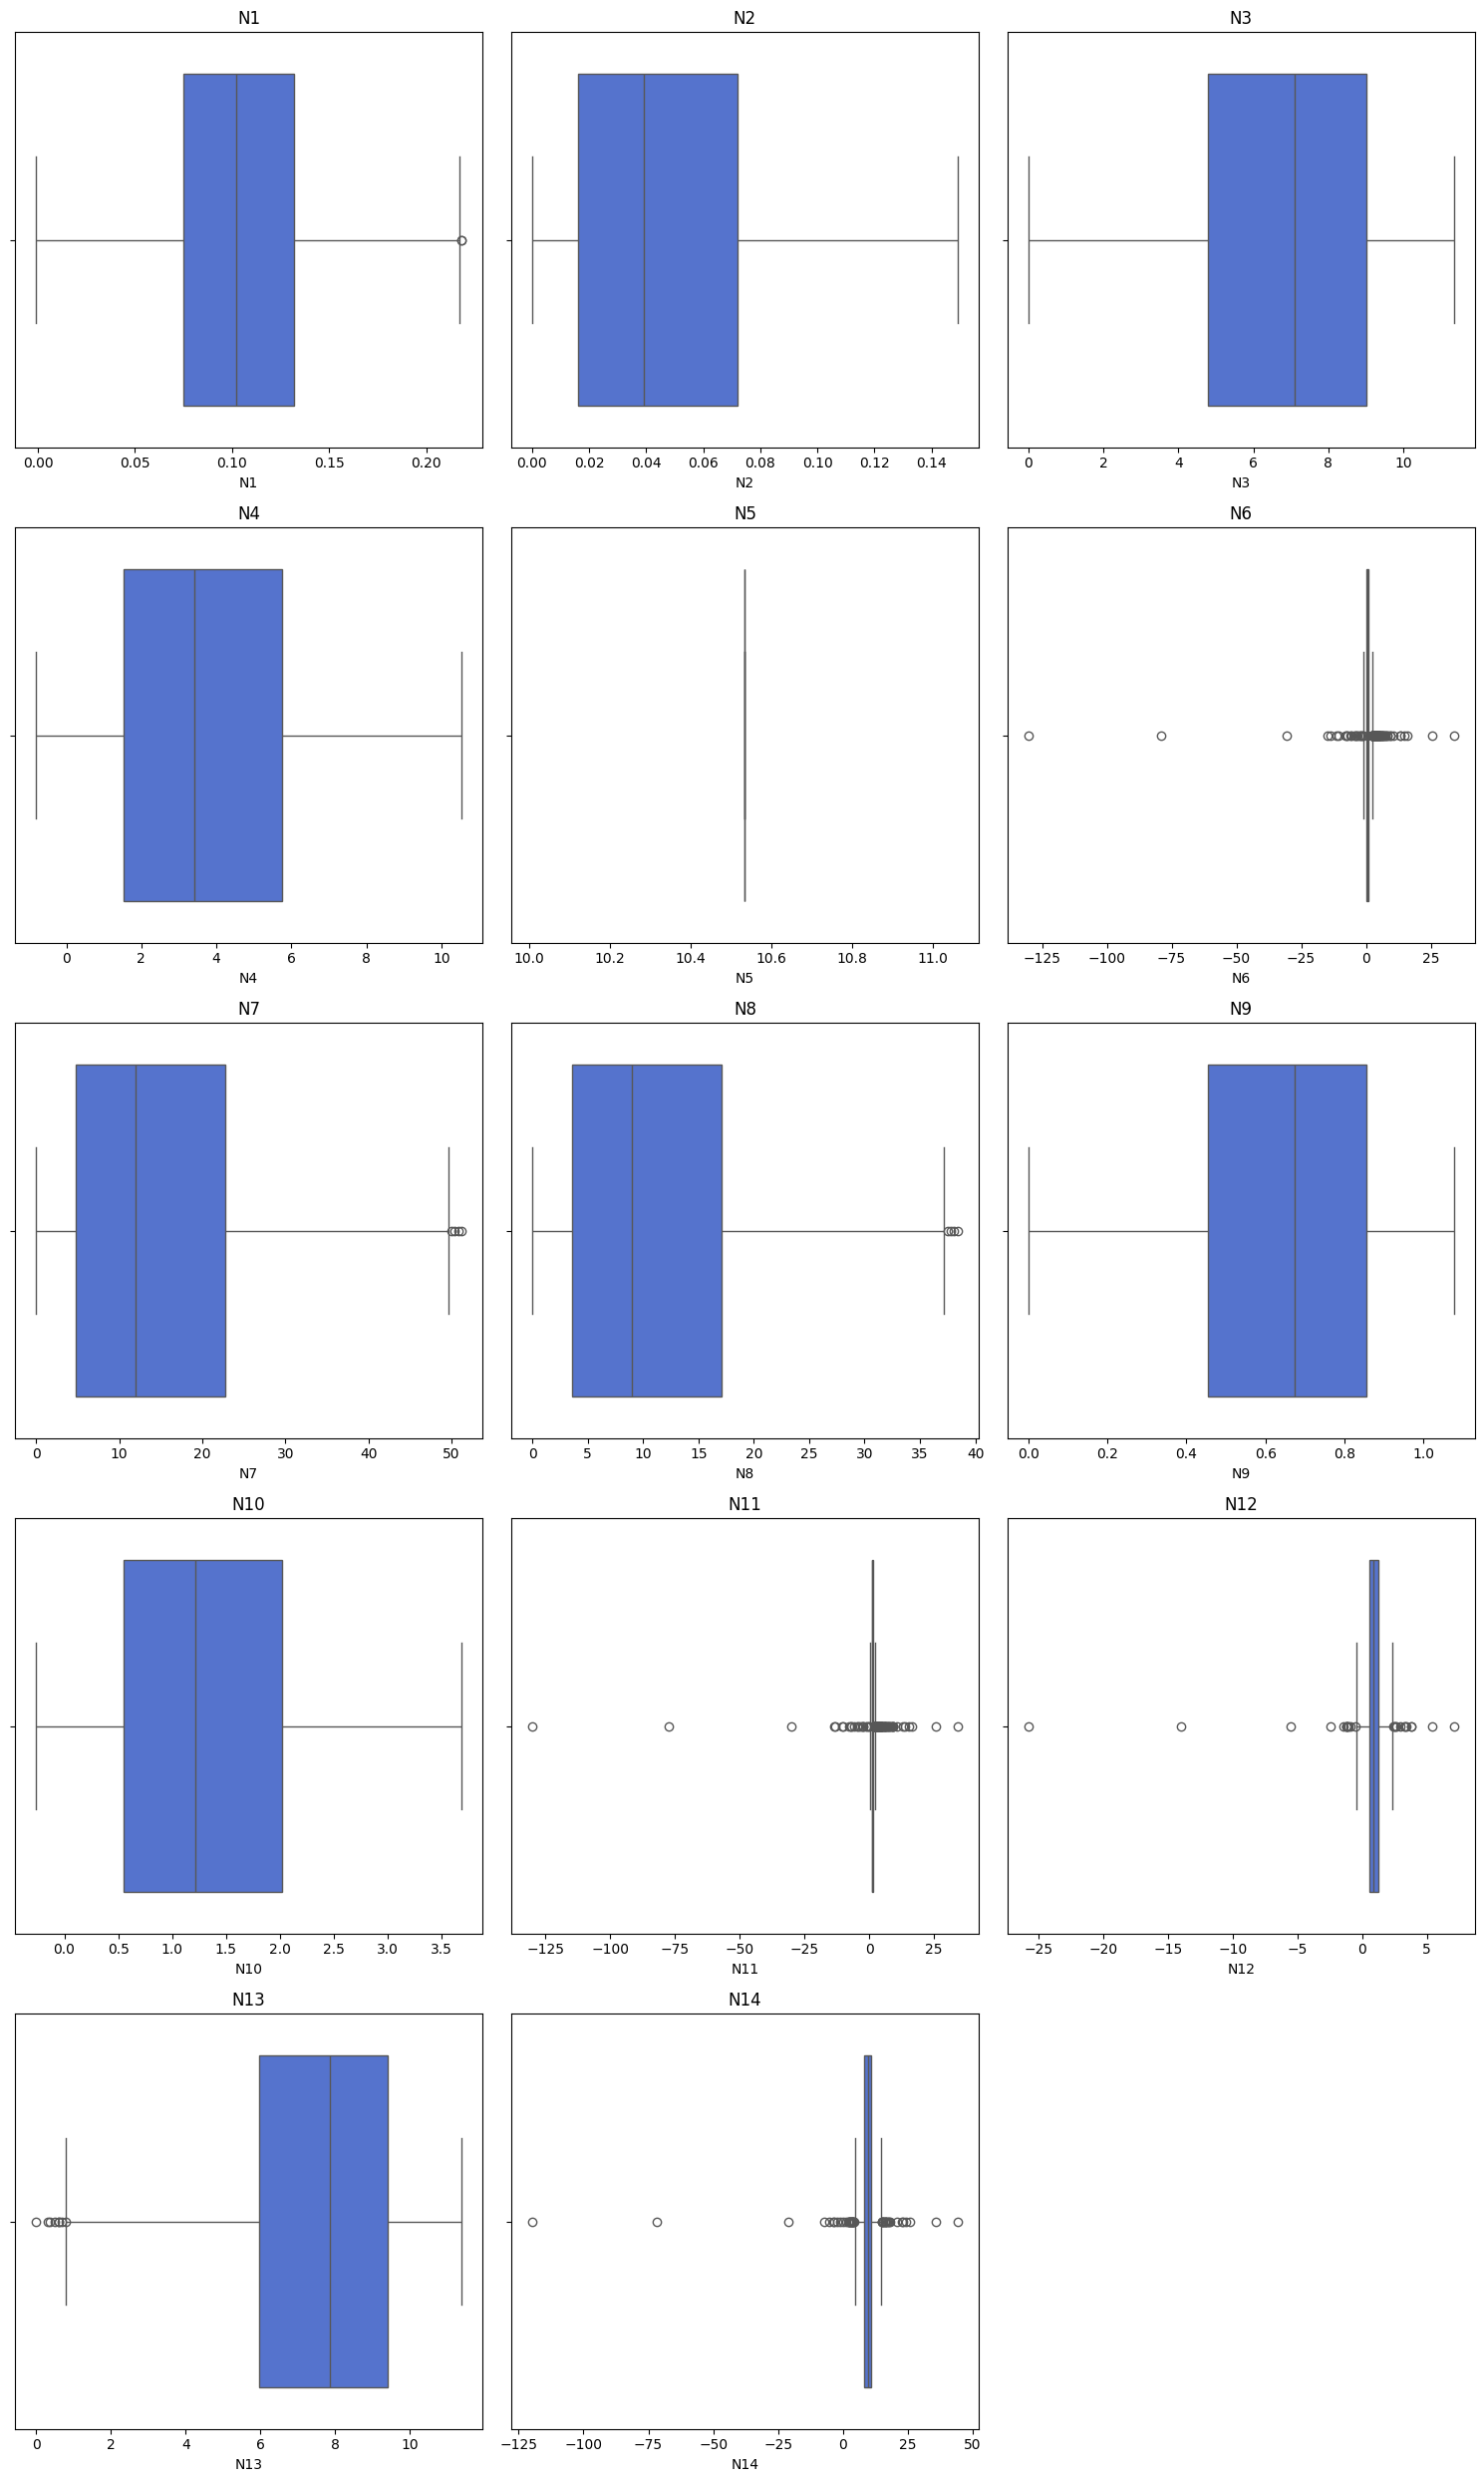

In [11]:
numerical_clustering_features = relay_state_data.select_dtypes(include='number').columns
num_cols = 3
num_rows = (len(numerical_clustering_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*5))
axes = axes.flatten()

for index, feature in enumerate(numerical_clustering_features):
    sns.boxplot(data=relay_state_data, x=feature, ax=axes[index], color='royalblue')
    axes[index].set_title(feature.title())

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

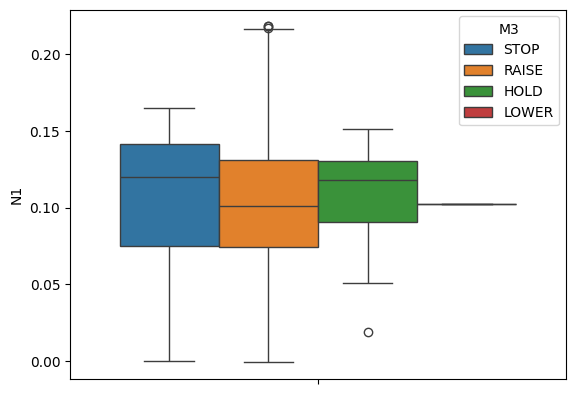

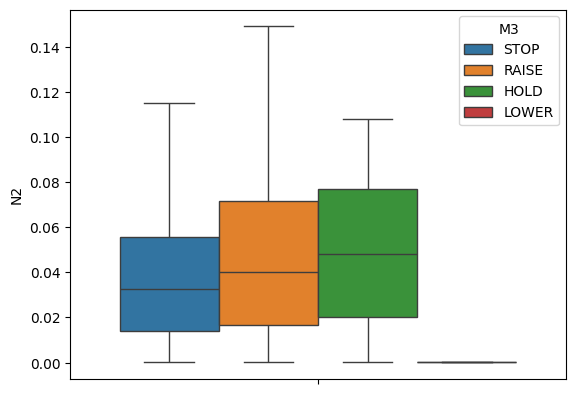

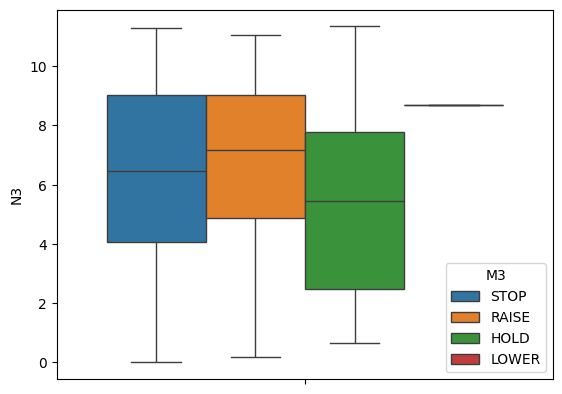

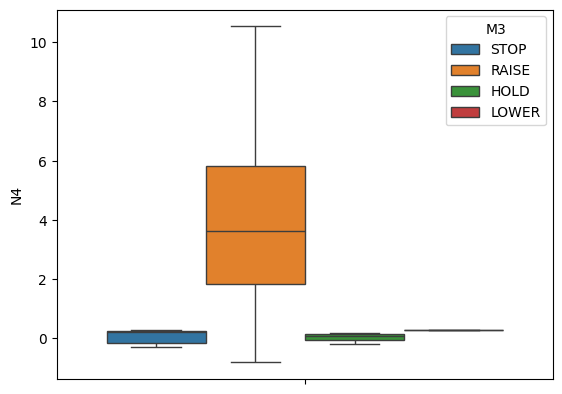

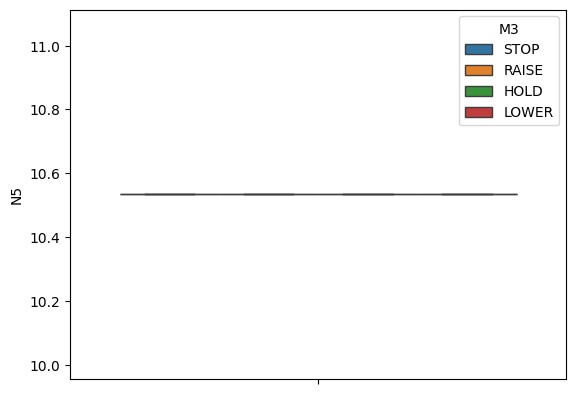

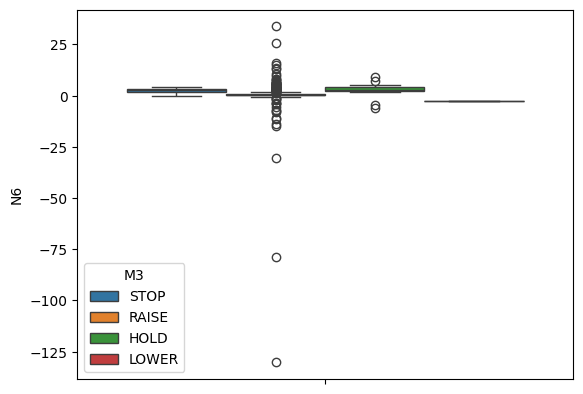

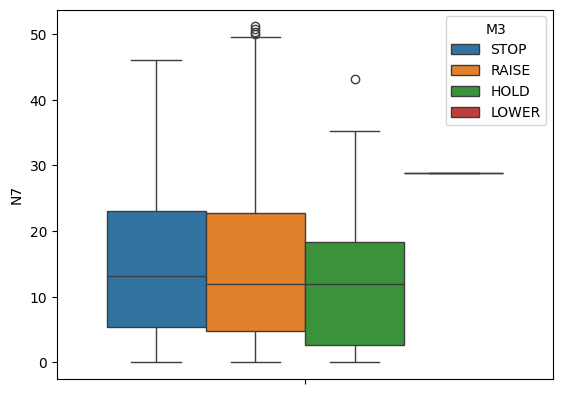

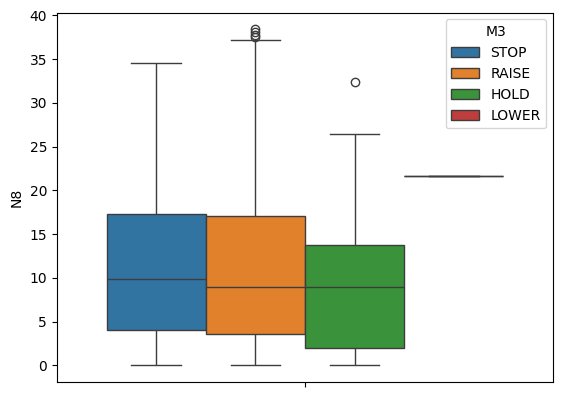

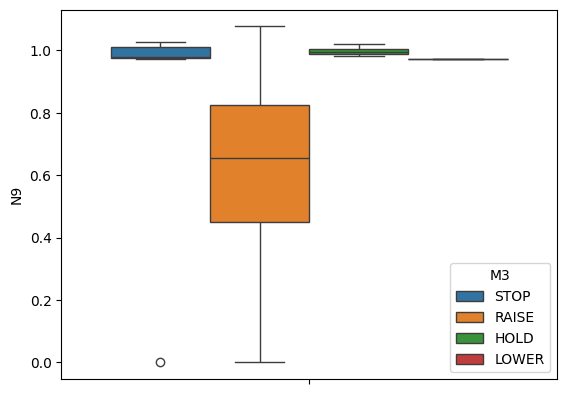

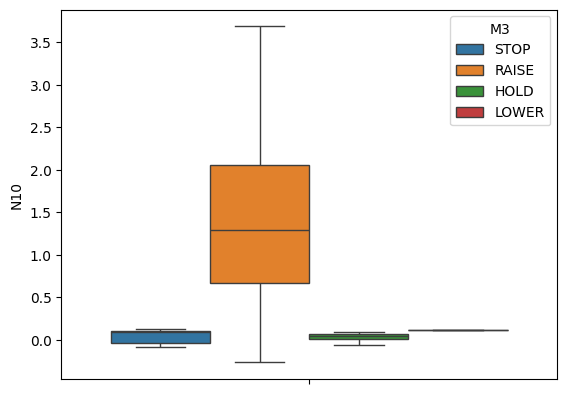

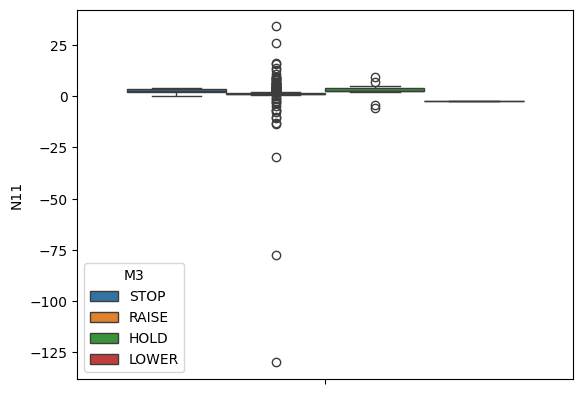

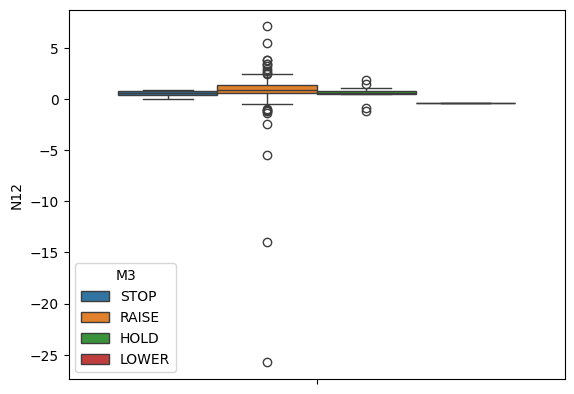

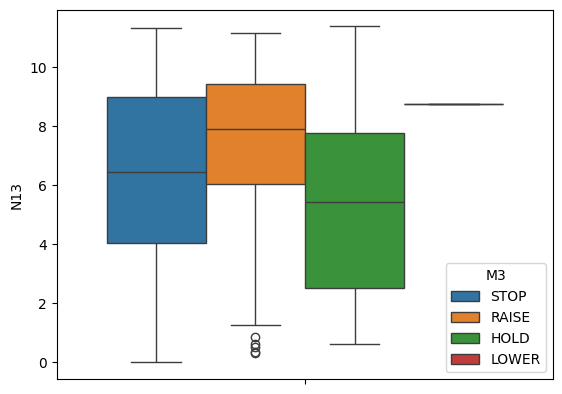

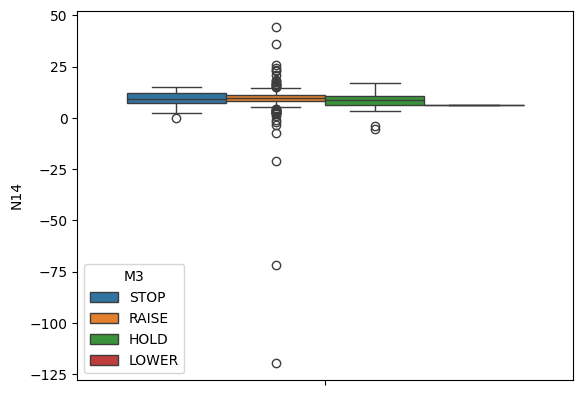

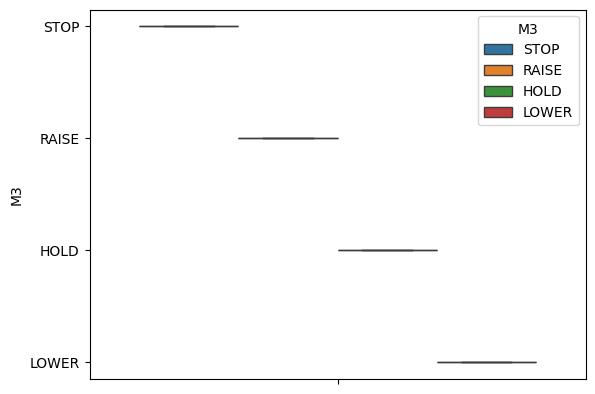

In [12]:
for feature in relay_state_data.columns:
    sns.boxplot(hue=relay_state_data['M3'], y=relay_state_data[feature], legend=True)
    plt.show()

In [13]:
input_data = relay_state_data.drop(labels='M3', axis=1)
output_data = relay_state_data['M3']

In [14]:
input_data.skew()

N1      0.044946
N2      0.668450
N3     -0.459688
N4      0.460030
N5      0.000000
N6    -16.065244
N7      0.838570
N8      0.838570
N9     -0.464608
N10     0.460153
N11   -16.444835
N12   -13.816331
N13    -0.662465
N14   -13.772146
dtype: float64

In [15]:
print("Performing winsorisation.")
for feature in input_data.columns:
    lower_bound = input_data[feature].quantile(0.05)
    upper_bound = input_data[feature].quantile(0.95)
    
    input_data[feature] = input_data[feature].clip(lower=lower_bound, upper=upper_bound)
print("Winsorisation completed.")
input_data.skew()

Performing winsorisation.
Winsorisation completed.


N1     0.088037
N2     0.476326
N3    -0.388655
N4     0.389089
N5     0.000000
N6     1.784929
N7     0.691102
N8     0.691099
N9    -0.389710
N10    0.390794
N11    2.232710
N12    0.727631
N13   -0.406717
N14   -0.053973
dtype: float64

In [16]:
print("Since feature 'N6' has a very large skew even now, we shall further clip it.")
lower_bound = input_data['N6'].quantile(0.00)
upper_bound = input_data['N6'].quantile(0.85)

input_data['N6'] = input_data['N6'].clip(lower=lower_bound, upper=upper_bound)
input_data.skew()

Since feature 'N6' has a very large skew even now, we shall further clip it.


N1     0.088037
N2     0.476326
N3    -0.388655
N4     0.389089
N5     0.000000
N6     0.784507
N7     0.691102
N8     0.691099
N9    -0.389710
N10    0.390794
N11    2.232710
N12    0.727631
N13   -0.406717
N14   -0.053973
dtype: float64

In [17]:
input_features = input_data.columns
standard_scaler = StandardScaler()
input_data = standard_scaler.fit_transform(input_data)
input_data = pd.DataFrame(data=input_data, columns=input_features)
input_data.head(2)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14
0,-1.754754,-1.291131,-1.924699,-1.389944,0.0,-1.049204,-1.194069,-1.19407,-1.922622,-1.384816,-0.700027,-1.143089,-1.918417,-1.854856
1,-1.754754,-1.291131,-1.924699,1.924184,0.0,-0.752713,-1.194069,-1.19407,-1.922622,1.926147,0.740112,2.123419,-1.918417,-1.675705


In [18]:
input_data.std()

N1     1.000558
N2     1.000558
N3     1.000558
N4     1.000558
N5     0.000000
N6     1.000558
N7     1.000558
N8     1.000558
N9     1.000558
N10    1.000558
N11    1.000558
N12    1.000558
N13    1.000558
N14    1.000558
dtype: float64

In [19]:
print("Dropping N5 as there is no meaningful data present. Zero variance.")
input_data.drop(labels='N5', axis=1, inplace=True)

Dropping N5 as there is no meaningful data present. Zero variance.


In [20]:
inertia = []
for n in range (1, 16):
    k_means_model = KMeans(n_clusters=n, 
                           init='k-means++', 
                           n_init=30, 
                           max_iter=300, 
                           tol=0.0001, 
                           random_state=0,
                           algorithm='lloyd')
    k_means_model.fit(input_data)
    inertia.append(k_means_model.inertia_)
print("Within Cluster Sum of Squares (i.e Intertia) is:", inertia)

Within Cluster Sum of Squares (i.e Intertia) is: [11660.999999999998, 7598.332627001968, 6518.213252773174, 5594.170110464873, 4832.786350598793, 4323.95580510741, 3821.892090823798, 3505.1789534548016, 3302.1142138467644, 3104.419007883644, 2914.65729577683, 2770.167201920095, 2658.504188697418, 2550.944034371538, 2479.080816063908]


In [21]:
n_clusters_range = range(1, len(inertia) + 1)
kneedle = KneeLocator(n_clusters_range, inertia, curve="convex", direction="decreasing")
optimal_clusters = kneedle.elbow
print(f"The optimum number of clusters (by elbow method) is {optimal_clusters}.")

The optimum number of clusters (by elbow method) is 5.


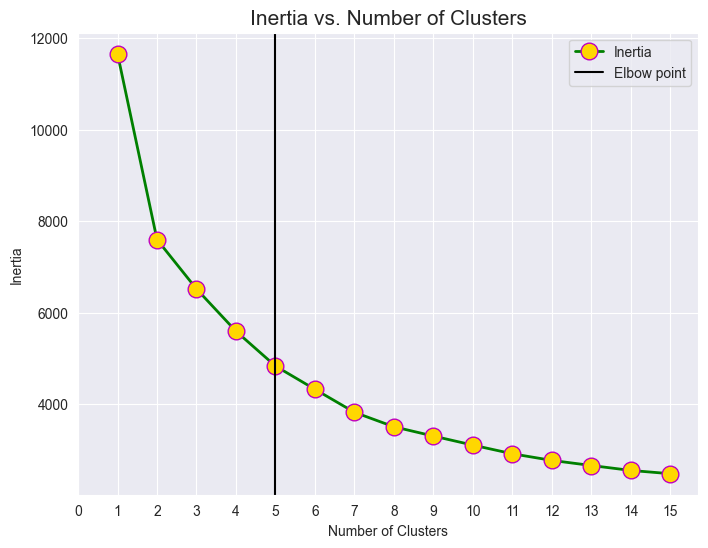

In [22]:
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
plt.plot(list(range(1, 16)), 
         inertia, 
         linewidth=2, 
         markersize=12, 
         color='green', 
         marker='o', 
         markerfacecolor='gold', 
         markeredgecolor='m', 
         label='Inertia')

plt.axvline(x=optimal_clusters, color='black', label='Elbow point')

plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Inertia', fontsize=10)
plt.xticks(range(0, 16, 1))
plt.title('Inertia vs. Number of Clusters', fontsize=15)
plt.legend()
plt.show()

In [23]:
cluster_range = range(2, 16)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    n_init=30,
                    max_iter=200,
                    tol=0.0001,
                    random_state=0,
                    algorithm='elkan')
    cluster_labels = kmeans.fit_predict(input_data)
    score = silhouette_score(input_data, cluster_labels)
    silhouette_scores.append(score)

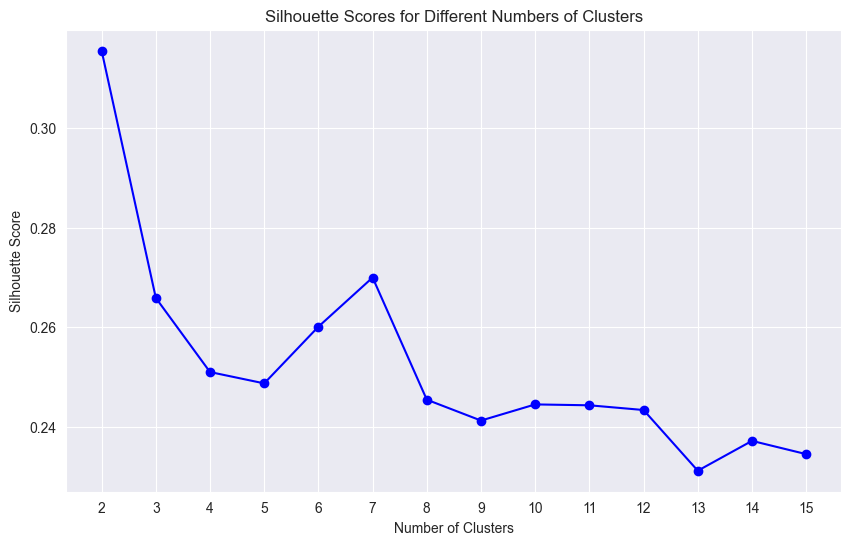

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

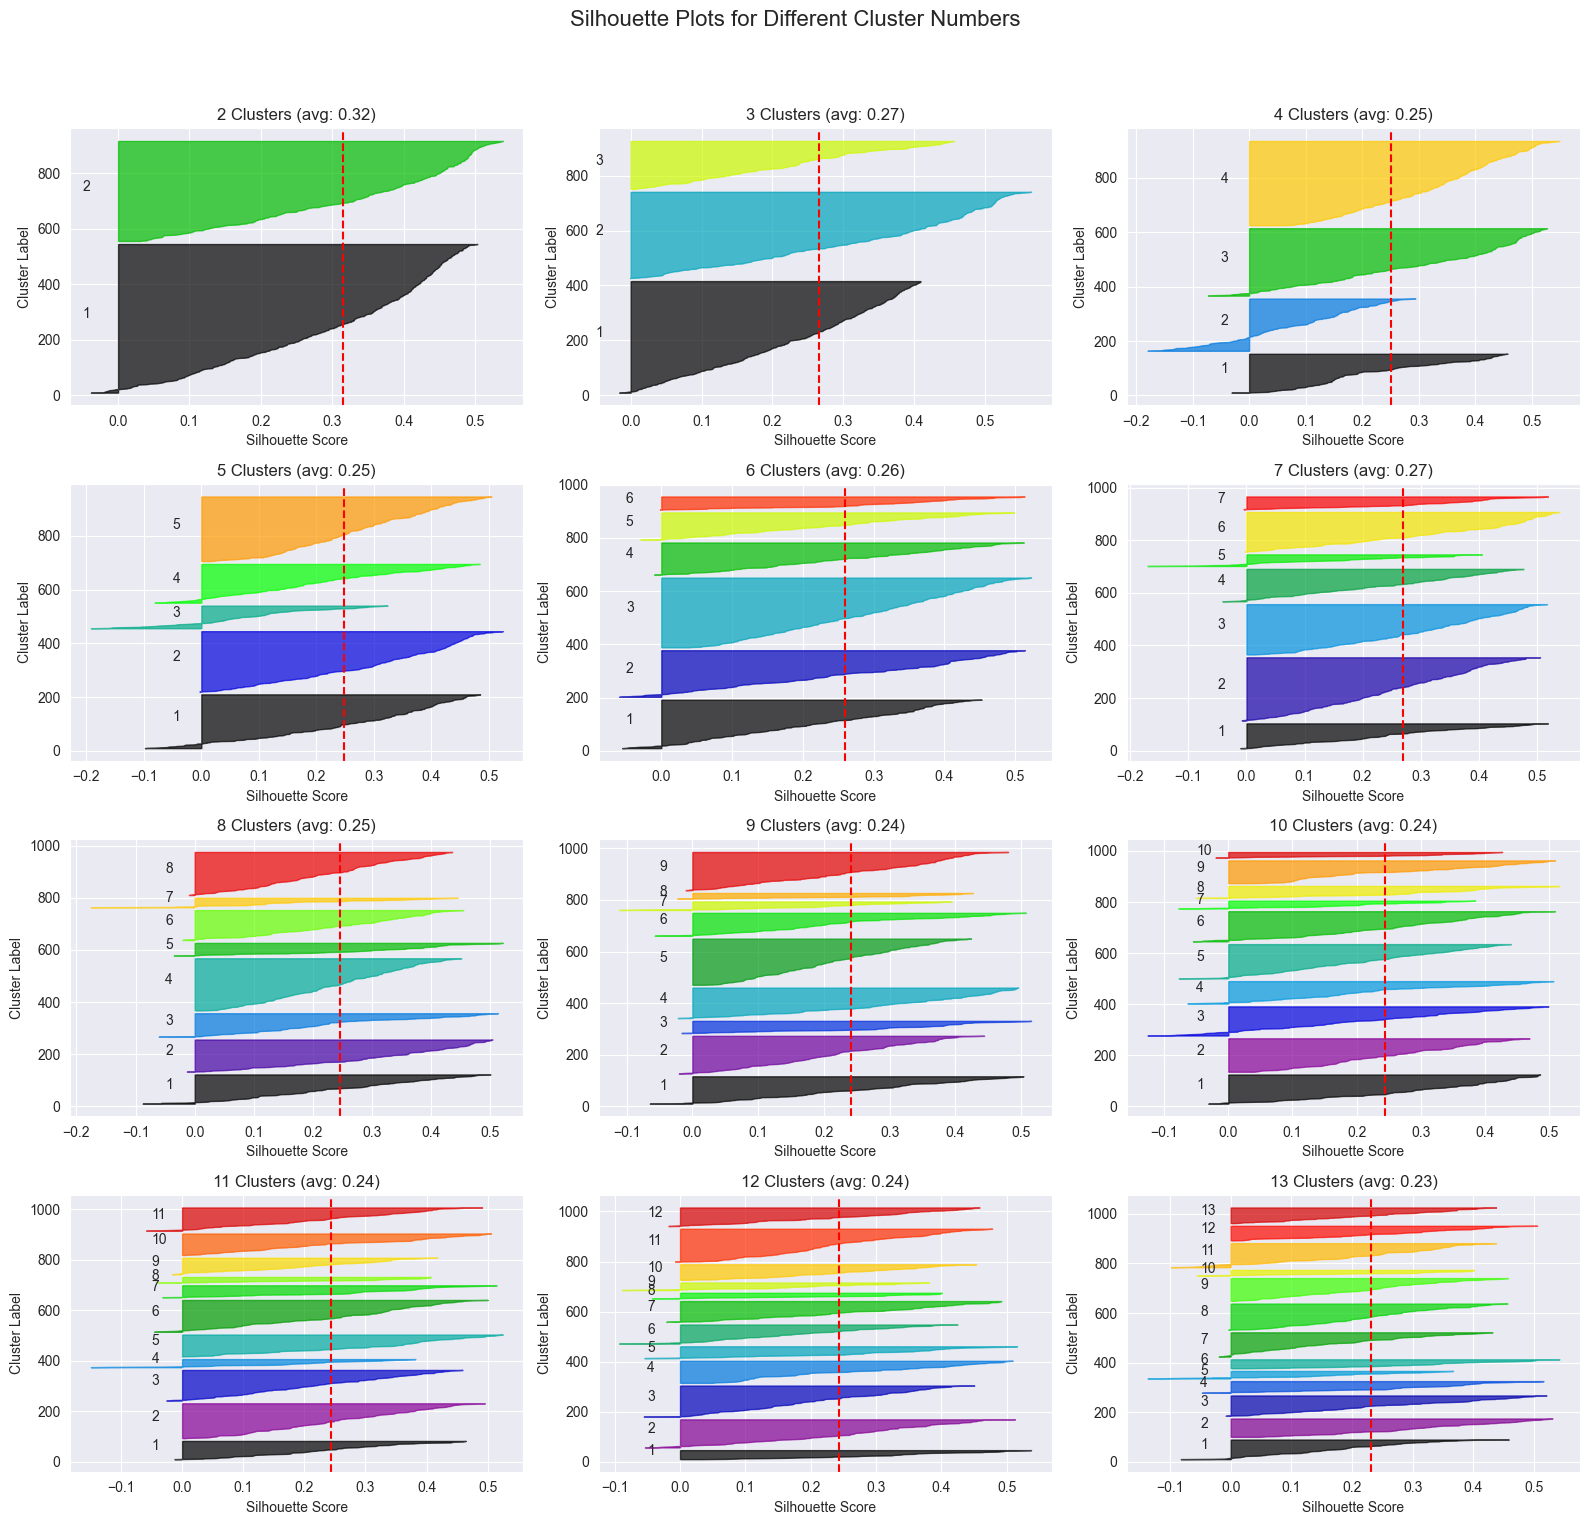

In [25]:
range_n_clusters = range(2, 14)

n_rows = 4
n_cols = 3

sns.set_style('darkgrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
fig.suptitle("Silhouette Plots for Different Cluster Numbers", fontsize=16)

for idx, n_clusters in enumerate(range_n_clusters):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    model = KMeans(n_clusters=n_clusters,
                   init='k-means++', 
                   n_init=30, 
                   max_iter=200, 
                   tol=0.0001, 
                   random_state=0,
                   algorithm='elkan')
    cluster_labels = model.fit_predict(input_data)

    average_silhouette_score = silhouette_score(input_data, cluster_labels)
    sample_silhouette_values = silhouette_samples(input_data, cluster_labels)
    
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
        y_lower = y_upper + 10

    ax.axvline(x=average_silhouette_score, color="red", linestyle="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster Label")
    ax.set_title(f"{n_clusters} Clusters (avg: {average_silhouette_score:.2f})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- The KneeLocator gave us an optimum k value of 5. But this doesn't seem to be the case.
- The elbow plot shows that k=3 might be a better value.
- Further, if we observe the silhouette scores and the silhouette plots, it is very clear that at k=5, there is a lot of leakage indicating the presence of outliers.
- Hence, going with k=3 is a good idea.

In [26]:
k_means_model = KMeans(n_clusters=5, 
                       init='k-means++', 
                       n_init=30, 
                       max_iter=200, 
                       tol=0.0001, 
                       random_state=0,
                       algorithm='elkan')
cluster_labels = k_means_model.fit_predict(input_data)

In [27]:
relay_state_data['Cluster_KMeans'] = cluster_labels
relay_state_data.head(2)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,M3,Cluster_KMeans
0,0.0001,0.0001,0.000100,0.000100,10.533904,0.02,0.0001,0.0010,0.000100,0.000055,0.020028,0.004033,0.000120,0.020175,STOP,4
1,0.0001,0.0001,0.649088,10.533804,10.533904,0.20,0.0001,0.0001,0.000009,3.686851,2.043426,2.252111,2.755849,6.642700,RAISE,0


In [28]:
relay_state_data['Cluster_KMeans'].unique()

array([4, 0, 1, 2, 3])

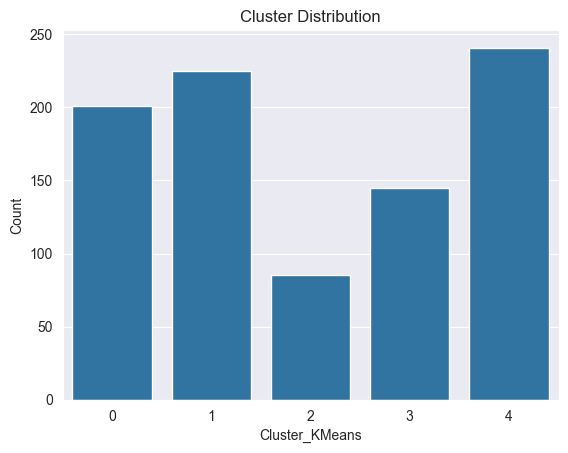

In [29]:
sns.countplot(data=relay_state_data, x='Cluster_KMeans')
plt.title('Cluster Distribution')
plt.xlabel('Cluster_KMeans')
plt.ylabel('Count')
plt.show()

In [30]:
actual_labels = relay_state_data['M3']
predicted_clusters = relay_state_data['Cluster_KMeans']

# Step 1: Create a contingency table
contingency_table = pd.crosstab(predicted_clusters, actual_labels)

# Step 2: Determine the mapping (label with highest count in each cluster)
cluster_to_label = contingency_table.idxmax(axis=1)

# Step 3: Map the predicted clusters to the actual labels
mapped_predictions = predicted_clusters.map(cluster_to_label)

# Calculate accuracy after mapping
accuracy = accuracy_score(actual_labels, mapped_predictions)
print(f"Accuracy after mapping: {accuracy:.2f}")

Accuracy after mapping: 0.95


### Trying out agglomerative clustering as well.

In [31]:
agglomerative_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_labels  = agglomerative_model.fit_predict(input_data)
relay_state_data['Cluster_Agglomerative'] = cluster_labels
relay_state_data.head(2)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,M3,Cluster_KMeans,Cluster_Agglomerative
0,0.0001,0.0001,0.000100,0.000100,10.533904,0.02,0.0001,0.0010,0.000100,0.000055,0.020028,0.004033,0.000120,0.020175,STOP,4,0
1,0.0001,0.0001,0.649088,10.533804,10.533904,0.20,0.0001,0.0001,0.000009,3.686851,2.043426,2.252111,2.755849,6.642700,RAISE,0,3


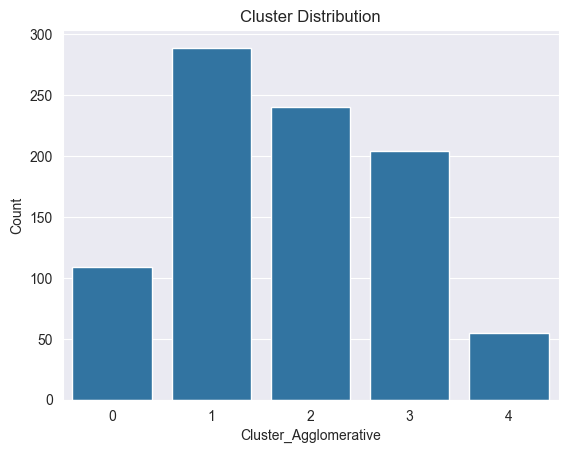

In [32]:
sns.countplot(data=relay_state_data, x='Cluster_Agglomerative')
plt.title('Cluster Distribution')
plt.xlabel('Cluster_Agglomerative')
plt.ylabel('Count')
plt.show()

In [33]:
actual_labels = relay_state_data['M3']
predicted_clusters = relay_state_data['Cluster_Agglomerative']

# Step 1: Create a contingency table
contingency_table = pd.crosstab(predicted_clusters, actual_labels)

# Step 2: Determine the mapping (label with highest count in each cluster)
cluster_to_label = contingency_table.idxmax(axis=1)

# Step 3: Map the predicted clusters to the actual labels
mapped_predictions = predicted_clusters.map(cluster_to_label)

# Calculate accuracy after mapping
accuracy = accuracy_score(actual_labels, mapped_predictions)
print(f"Accuracy after mapping: {accuracy:.2f}")

Accuracy after mapping: 0.95


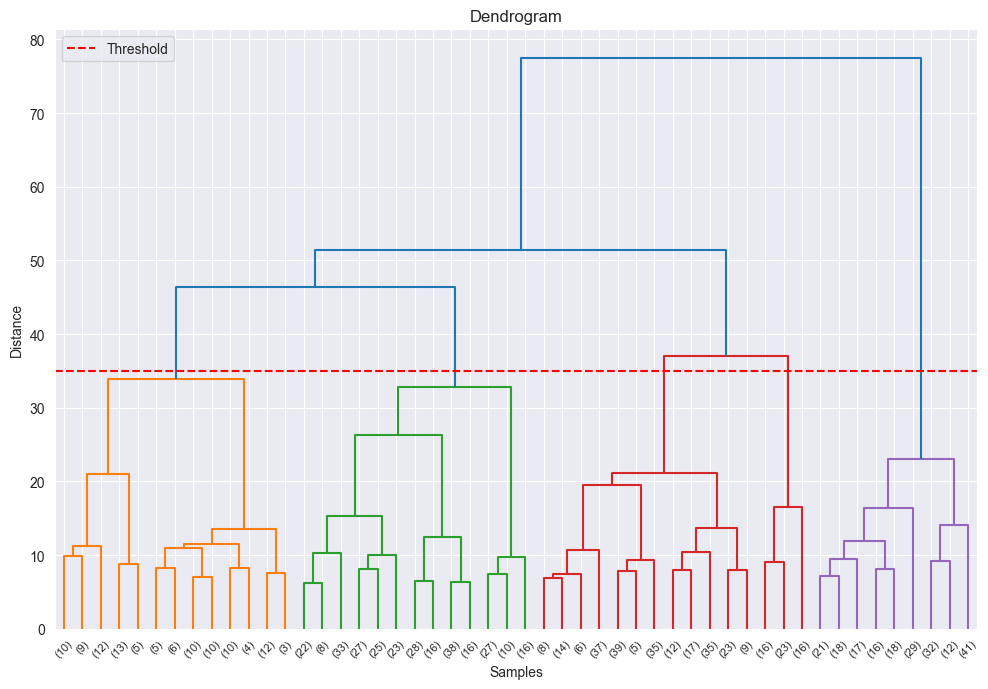

In [34]:
linked = linkage(input_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp', 
           color_threshold=40,
           p=50)

plt.axhline(y=35, color='r', linestyle='--', label="Threshold")
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
submission_dataframe = pd.DataFrame({
    'Index': input_data.index,
    'Cluster': relay_state_data['Cluster_Agglomerative']
})
submission_dataframe.sort_values(by="Index", inplace=True)

In [36]:
submission_dataframe_file = ('../d. Output Files/RelayStates/' + 'RelayStates_Clustering_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: RelayStates_Clustering_Prediction.csv


## Classification

In [37]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=0)
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)

y_test_pred = random_forest_model.predict(X_test)

print('The number of input feature ', X_train.shape[1])
print(classification_report(y_test, y_test_pred))

The number of input feature  13
              precision    recall  f1-score   support

        HOLD       0.43      1.00      0.60         3
       RAISE       1.00      0.99      1.00       173
        STOP       1.00      0.25      0.40         4

    accuracy                           0.98       180
   macro avg       0.81      0.75      0.67       180
weighted avg       0.99      0.98      0.98       180



In [38]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy score on the full data: {round(accuracy * 100, 2)}")

Accuracy score on the full data: 97.78


In [39]:
pca = PCA(n_components = input_data.shape[1])
pca_data = pca.fit_transform(input_data)
exp_var_ratio= pca.explained_variance_ratio_
exp_var_ratio.round(3)

cum_var = exp_var_ratio[0]
itr=2 # Defined as two as first pc1 variance defined outside the loop
for j in exp_var_ratio[1:]:
    cum_var = cum_var + j
    if cum_var >= 0.95:
        break
    itr = itr + 1

print(f'The number of principle components capturing 95% varaition is : {itr} Varaince explained is {cum_var}')

The number of principle components capturing 95% varaition is : 6 Varaince explained is 0.9849817740140986


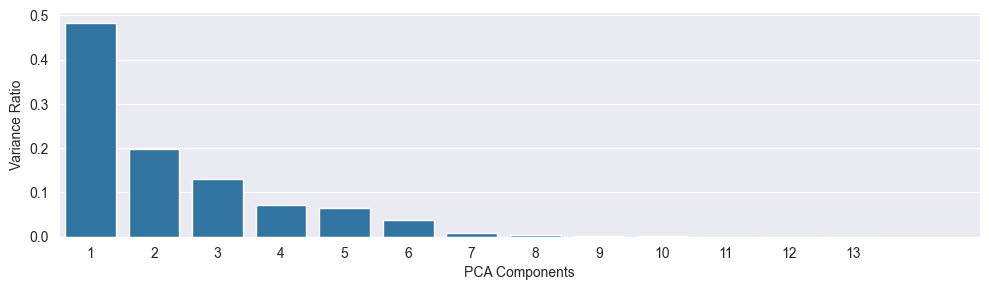

In [40]:
plt.figure(figsize=(10, 3))
sns.barplot(x=range(1, len(pca.explained_variance_ratio_) + 1), y=pca.explained_variance_ratio_)
plt.xlabel("PCA Components")
plt.ylabel("Variance Ratio")
plt.xticks(range(0, 15))
plt.tight_layout()
plt.show()

In [41]:
# PC1 is derived from first eigen vector
eigen_vector_1 = pd.DataFrame(pca.components_[0,:]) # first eigen vector
eigen_vector_1.index = input_data.columns
e11 = np.abs(eigen_vector_1)
print('Top 5 features contributing in PC1')
e11.sort_values(0, ascending=False).head(5)

Top 5 features contributing in PC1


,0
N9,0.383543
N4,0.382860
N10,0.382843
N3,0.361357
N13,0.346008


In [42]:
X_train, X_test, y_train, y_test = train_test_split(pca_data[:,:5], output_data, test_size=0.2, random_state=0)
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)

y_test_pred = random_forest_model.predict(X_test)

print('The number of input feature ', X_train.shape[1])
print(classification_report(y_test, y_test_pred))

The number of input feature  5
              precision    recall  f1-score   support

        HOLD       0.00      0.00      0.00         3
       RAISE       0.97      0.99      0.98       173
        STOP       0.00      0.00      0.00         4

    accuracy                           0.96       180
   macro avg       0.32      0.33      0.33       180
weighted avg       0.93      0.96      0.94       180



In [43]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy score on the PCA data: {round(accuracy * 100, 2)}")

Accuracy score on the PCA data: 95.56


In [44]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=0)

In [45]:
submission_dataframe = pd.DataFrame({
    'Index': X_test.index,
    'Cluster': y_test_pred
})
submission_dataframe.sort_values(by="Index", inplace=True)

In [46]:
submission_dataframe_file = ('../d. Output Files/RelayStates/' + 'RelayStates_Clustering_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: RelayStates_Classification_Prediction.csv
